# TP Observations Nocturnes - LU3PY232
**ARGUELLO Camilo**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from utils import pc2m, m2pc, dms2deg, deg2dms, flux2mag, mag2flux, distance_modulus, apparent_to_absolute_flux
from constants import ConstantesAstro

## 1. Introduction et Contexte

### Objectifs du TP

Ce TP vise à étudier la relation d’échelle entre la taille et la luminosité des galaxies de l’univers proche. 
Nous allons utiliser des images obtenues à l'aide de télescopes à distance pour :

- Calibrer des images photométriques (offset, flat field),
- Extraire des informations scientifiques (taille, luminosité),
- Comparer les résultats avec les théories d’assemblage galactique.


### Diversité morphologique des galaxies

// TODO

### Loi d'échelle taille-luminosité

// TODO

//  explication des relations taille-masse et leur interprétation physique


### Messier 83
// TODO

## 2. Prise en main et visualisation des images de M83

> Quel est l’ordre de grandeur de la brillance de surface des etoiles ?  la brillance de surface du fond de ciel ? La brillance de surface de la galaxie ? En quelle unit´e est le flux sur ces images non-calibr´ees ?

Filename: ./M83/M83-Red-140-002.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (4096, 4096)   int16 (rescales to uint16)   
SIMPLE  =                    T                                                  BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     NAXIS   =                    2 /number of axes                                  NAXIS1  =                 4096 /fastest changing axis                           NAXIS2  =                 4096 /next to fastest changing axis                   BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           DATE-OBS= '2023-05-09T11:35:58.93' /YYYY-MM-DDThh:mm:ss observation, UT         EXPTIME =   140.00000000000000 /Exposure time in seconds                        EXPOSURE=   140.00000000000000 /Exposure time in seconds                        SET-TEMP=  -15.

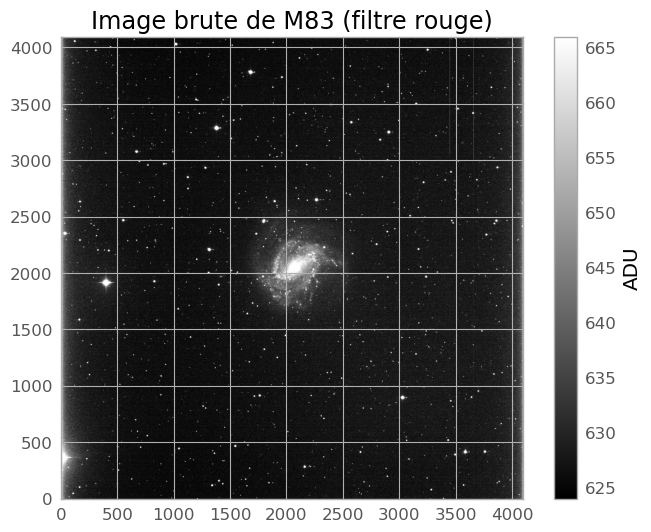

In [46]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Ouvrir le fichier FITS
hdulist = fits.open('./M83/M83-Red-140-002.fit')

# Afficher le contenu (structure du fichier)
hdulist.info()

# Stocker les données de l'image dans une variable tab
tab = hdulist[0].data

# Afficher l'entête (header)
header = hdulist[0].header
data = hdulist[0].data
print(header)

# Maintenant afficher l'image
plt.imshow(tab, cmap='gray', origin='lower', vmin=np.percentile(data,50) , vmax=np.percentile(data,99))
plt.colorbar(label='ADU')  # Pour voir l'échelle de flux
plt.title('Image brute de M83 (filtre rouge)')
plt.show()

# Fermer le fichier FITS proprement
hdulist.close()


./M83/M83-Red-140-001.fit
./M83/M83-Blue-140-001.fit
./M83/M83-Green-140-001.fit


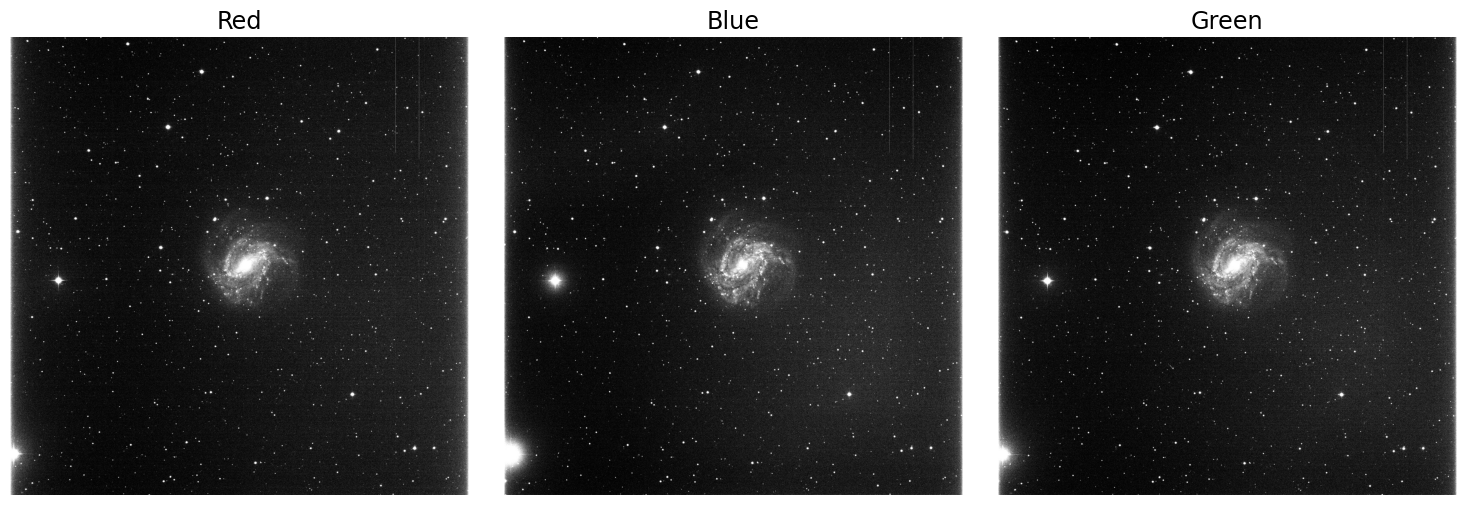

In [ ]:
import matplotlib.pyplot as plt
from astropy.io import fits
import glob

# Trouver tous les fichiers FITS correspondant à chaque filtre
red_files = sorted(glob.glob('./M83/M83-Red-*.fit'))
blue_files = sorted(glob.glob('./M83/M83-Blue-*.fit'))
green_files = sorted(glob.glob('./M83/M83-Green-*.fit'))

index = 0

# Optionnel : prendre seulement un sous-ensemble pour pas surcharger l'affichage
files_to_plot = [red_files[index], blue_files[index], green_files[index]]  # premier de chaque filtre

fig, axes = plt.subplots(1, len(files_to_plot), figsize=(15, 5))  # 1 ligne, autant de colonnes que d'images

for ax, file in zip(axes, files_to_plot):
    print(file)
    with fits.open(file) as hdulist:
        data = hdulist[0].data
    im = ax.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data,50) , vmax=np.percentile(data,99))
    ax.set_title(file.split('-')[1])  # Mettre le filtre dans le titre
    ax.axis('off')
plt.tight_layout()
plt.show()


> Quelle est la durée de la pose ? Quelle était la date d’observation ?

> Que pouvez-vous dire de la qualité de cette image ? Quelle est la valeur typique du fond de ciel ?

In [ ]:
fond_ciel = tab[100:200, 100:200]  # Un petit carré dans une région vide
print(fond_ciel.mean()) # ADU

634.3335


> Répondez aux mêmes questions avec une image dans un autre filtre. Que constatez vous ? Faites bien attention à prendre en compte le temps de pose lorsque vous comparez les flux.

> Convertissez la taille d’un pixel sur l’image en secondes d’arc puis en kiloparsecs, sachant la distance de cette galaxie (se référer au fichier excel TP 2025 galaxies.xlsx). Justifiez. En le mesurant “à la main”, quel est le rayon caractéristique ce cette galaxie, en `kpc` ?

In [53]:
hdul = fits.open('./M83/M83-Red-140-001.fit')
header = hdul[0].header

SIMPLE  =                    T                                                  BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     NAXIS   =                    2 /number of axes                                  NAXIS1  =                 4096 /fastest changing axis                           NAXIS2  =                 4096 /next to fastest changing axis                   BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           DATE-OBS= '2023-05-09T11:32:42.84' /YYYY-MM-DDThh:mm:ss observation, UT         EXPTIME =   140.00000000000000 /Exposure time in seconds                        EXPOSURE=   140.00000000000000 /Exposure time in seconds                        SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   CCD-TEMP=  -15.055498123168945 /CCD temperature at start of exposure in C       XPIXSZ  =   9.0000000000000000 /Pixel Wi

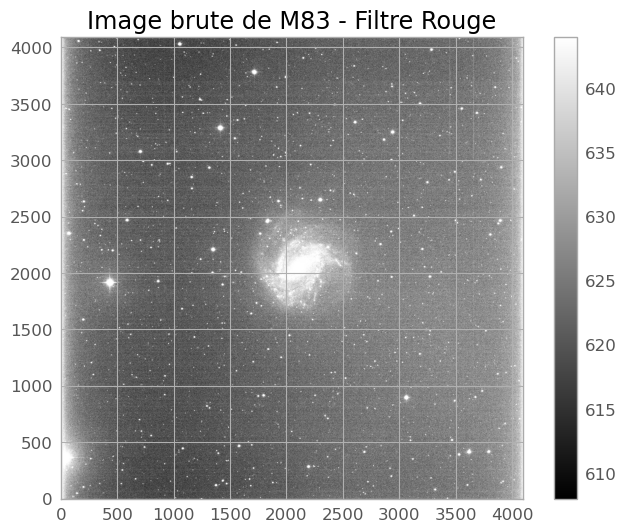

In [55]:
hdul = fits.open("./M83/M83-Red-140-001.fit")
data = hdul[0].data
header = hdul[0].header

print(header)
plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
plt.colorbar()
plt.title("Image brute de M83 - Filtre Rouge")
plt.show()

## 3. Calibration des images

In [ ]:

offset_hdul = fits.open("offset_001.fit")
offset_data = offset_hdul[0].data

plt.hist(offset_data.flatten(), bins=100)
plt.title("Histogramme des valeurs d'une pose d'offset")
plt.xlabel("Valeurs")
plt.ylabel("Nombre de pixels")
plt.show()

# Construction de la pose maître d'offset
from processing import master_bias

offset_files = ["offset_001.fit", "offset_002.fit", ...]  # À compléter
bias_master = master_bias(offset_files)

# Sauvegarde
fits.writeto("master_bias.fits", bias_master, overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: 'offset_001.fit'

## 4. Pipeline de traitement

In [5]:
# Construction d'un pipeline de stacking
from processing import stacking

science_images = ["M83-Red-140-001.fit", "M83-Red-140-002.fit", ...]  # À compléter
stacked_image = stacking(science_images, bias=bias_master, flat="flat_master.fits")
fits.writeto("M83_Red_calibrated.fits", stacked_image, overwrite=True)

NameError: name 'bias_master' is not defined

## 5. Photométrie : taille et luminosité

In [ ]:
# Photométrie simple avec photutils
from photutils.aperture import CircularAperture, aperture_photometry

positions = [(x0, y0)]  # centre de la galaxie
radii = [10, 15, 20, 25, 30]  # à adapter

for r in radii:
    aperture = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(stacked_image, aperture)
    print(f"Rayon {r}: flux = {phot_table['aperture_sum']}")

## 6. Étude statistique loi taille-luminosité

In [6]:
# Exemple de tracé final
luminosities = [...]  # µJy
radii_kpc = [...]     # kpc
types = [...]         # par exemple ["spirale", "elliptique", ...]

plt.scatter(luminosities, radii_kpc, c=type_color_map[types], label=types)
plt.xlabel("Luminosité (µJy)")
plt.ylabel("Rayon effectif (kpc)")
plt.title("Relation taille-luminosité")
plt.legend()
plt.grid()
plt.show()

NameError: name 'type_color_map' is not defined

## 7. Discussion

- Incertitudes principales :
  * fond de ciel
  * étalonnage du point-zéro
  * qualité des poses
- Comportement selon le type morphologique ?
- Alignement avec les résultats de Gadotti (2009) ?